In [33]:
from IPython.display import display, Image as IPImage
import requests
from io import BytesIO
from PIL import Image
import evadb

In [34]:

class EvaDBManager:
    def __init__(self):
        self.conn = evadb.connect()
        self.cursor = self.conn.cursor()

    def query(self, sql):
        return self.cursor.query(sql).df()

    def create_function(self):
        self.query("""
            CREATE FUNCTION
            IF NOT EXISTS GenerateImage
            IMPL 'test.py';
        """)

    def setup_database(self):
        self.query("DROP TABLE IF EXISTS History")
        self.query("""
            CREATE TABLE History
            (id INTEGER,
            command TEXT(30),
            data TEXT(30));
        """)

    def insert_command_to_history(self, id, command):
        self.query(f"""
            INSERT INTO History (id, command, data ) VALUES
            ('{id}', '{command}', 'null');
        """)

    def get_generated_image_url(self, id):
        query = self.query(f"""
            SELECT GenerateImage(command).result FROM History
            WHERE id = {id};
        """)
        return query['generateimage.result'].iloc[0]

    def list_all_functions(self):
        return self.query("SHOW FUNCTIONS;")

    def cleanup(self):
        self.query("DROP FUNCTION GenerateImage")

In [35]:
def display_image_from_url_pop(url):
    response = requests.get(url)
    if response.status_code == 200:
        image_data = BytesIO(response.content)
        image = Image.open(image_data)
        image.show()
    else:
        print(f"Failed to retrieve the image. HTTP Status Code: {response.status_code}")


def display_image_from_url(url):
    response = requests.get(url)
    if response.status_code == 200:
        image_data = BytesIO(response.content)
        img = IPImage(data=image_data.getvalue())
        display(img)
    else:
        print(f"Failed to retrieve the image. HTTP Status Code: {response.status_code}")

In [37]:

# Connect to EvaDB
db_manager = EvaDBManager()

print("Welcome to Evadb based AI Image Generation Program !!")

# Create function for generating images
db_manager.create_function()

# Show functions
print(db_manager.list_all_functions())
print("Function Ready")

Downloading: "http://ml.cs.tsinghua.edu.cn/~chenxi/pytorch-models/mnist-b07bb66b.pth" to /Users/gaohaoyu/.cache/torch/hub/checkpoints/mnist-b07bb66b.pth


Welcome to Evadb based AI Image Generation Program !!
            name                                             inputs  \
0     ArrayCount   [Input_Array NDARRAY ANYTYPE (), Search_Key ANY]   
1           Crop  [Frame_Array NDARRAY UINT8 (3, None, None), bb...   
2        ChatGPT  [query NDARRAY STR (1,), content NDARRAY STR (...   
3   FuzzDistance         [data1 NDARRAY STR 1, data2 NDARRAY STR 1]   
4  GenerateImage                      [command NDARRAY STR (None,)]   

                                             outputs             type  \
0                                [key_count INTEGER]  NdarrayFunction   
1  [Cropped_Frame_Array NDARRAY UINT8 (3, None, N...  NdarrayFunction   
2                        [response NDARRAY STR (1,)]             None   
3                       [distance NDARRAY FLOAT32 1]             None   
4                       [result NDARRAY STR (None,)]             None   

                                                impl metadata  
0  /Users/gaohao

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /Users/gaohaoyu/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


/Users/gaohaoyu/Desktop/youtube_video_qa-main/venv/lib/python3.11/site-packages/evadb/storage/sqlite_storage_engine.py:113: SAWarning: This declarative base already contains a class with the same class name and module name as evadb.storage.sqlite_storage_engine.__placeholder_class_name__History, and will be replaced in the string-lookup table.
  new_table = type(


Please enter the image you want (or type 'exit' to quit):  a cute girl with a white cat


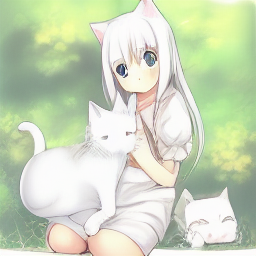

Please enter the image you want (or type 'exit' to quit):  a cool boy with a dog


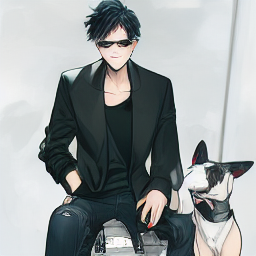

Please enter the image you want (or type 'exit' to quit):  a crying baby


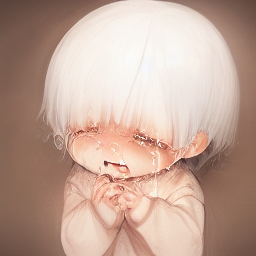

Please enter the image you want (or type 'exit' to quit):  a beautiful bird


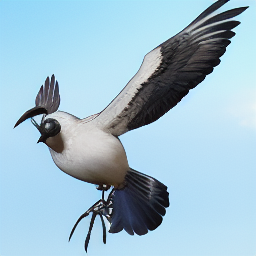

Please enter the image you want (or type 'exit' to quit):  exit


In [38]:
# Setup the database
db_manager.setup_database()

id = 1
while True:
    # Get user input from the command line
    user_input = input("Please enter the image you want (or type 'exit' to quit): ")

    # Check if the user wants to exit
    if user_input.lower() == 'exit':
        break

    # Insert command to history
    db_manager.insert_command_to_history(id, user_input)

    # Generate image
    url_image = db_manager.get_generated_image_url(id)

    # Display the image
    display_image_from_url(url_image)

    id += 1

# Cleanup
db_manager.cleanup()